# Imports
**Other**
* CPU monitoring in terminal:  
```bash
top
```
* GPU monitoring in terminal:  
```bash
pip install gpustat
watch -c gpustat -cp --color
```

In [1]:
import sys
from math import ceil
import pandas as pd
# to save results to data directory
module_path = '..'
if module_path not in sys.path:
    sys.path.insert(1, module_path)
# increase displayed columns in jupyter notebook
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 300)

In [2]:
import os
import torch
import multiprocessing
import json
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, RobustScaler, StandardScaler
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from pytorch_widedeep.dataloaders import DataLoaderImbalanced, DataLoaderDefault
from pytorch_widedeep.preprocessing import WidePreprocessor, TabPreprocessor
from pytorch_widedeep.training import Trainer
from pytorch_widedeep.models import Wide, TabMlp, WideDeep
from pytorch_widedeep.models.transformers.saint import SAINT
from pytorch_widedeep.callbacks import EarlyStopping, ModelCheckpoint, LRHistory
from pytorch_widedeep.initializers import KaimingNormal, XavierNormal
from pytorch_widedeep.callbacks import ModelCheckpoint, LRHistory, EarlyStopping
from pytorch_widedeep.optim import RAdam

from torch.optim import SGD, lr_scheduler
from torchmetrics import F1 as F1_torchmetrics
from torchmetrics import Accuracy as Accuracy_torchmetrics
from torchmetrics import Precision as Precision_torchmetrics
from torchmetrics import Recall as Recall_torchmetrics

# increase displayed columns in jupyter notebook
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 300)

# temporarily remove deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

**helper functions for scaling**

In [3]:
def intsec(list1, list2):
    """Simple intesection of two lists.

    Args:
        list1 (list): list1
        list2 (list): list2

    Returns:
        list (list): intersection of lists
    """
    return list(set.intersection(set(list1), set(list2)))


def scale(data_pd, non_scale_cols, scaler_sk='Standard'):
    """Procedure to scale the dataset except the given list of columns.

    Args:
        data_pd (obj): pandas dataframe
        non_scale_cols (list): columns to not scale
        scaler_sk (str, sklearn.peprocessing obj): type of scaler from['Standard', 'Yeo-Johnson',
        'Robust', 'MinMax'] or already fitted scaler

    Returns:
        tuple (tuple): data_pd_scaled (obj): scaled pandas dataframe\n
        scaler_sk (obj): sklearn scaler object
    """
    non_scale_cols = intsec(data_pd.columns.values, non_scale_cols)
    data_pd_toscale = data_pd.drop(columns=non_scale_cols)
    if type(scaler_sk) is str:
        if scaler_sk == 'Standard':
            scaler_sk = StandardScaler()
        elif scaler_sk == 'Yeo-Johnson':
            scaler_sk = PowerTransformer(method='yeo-johnson')
        elif scaler_sk == 'Robust':
            scaler_sk = RobustScaler()
        elif scaler_sk == 'MinMax':
            scaler_sk = MinMaxScaler()
        scaler_sk.fit(data_pd_toscale)
    # if 'sklearn.peprocessing' in str(type(scaler_sk)):

    data_pd_scaled = pd.DataFrame(scaler_sk.transform(data_pd_toscale),
                                  columns=data_pd_toscale.columns.values)
    data_pd_scaled[non_scale_cols] = data_pd[non_scale_cols].copy()
    return data_pd_scaled, scaler_sk

In [4]:
# https://discuss.pytorch.org/t/why-is-pytorch-using-only-the-half-of-cpu-cores-smt-enabled/69068
# https://pytorch.org/docs/stable/torch.html#parallelism
print('# PyTorch interop threads: {}\n'.format(str(torch.get_num_interop_threads())) +
      '# PyTorch threads: {}\n'.format(str(torch.get_num_threads())) +
      '# of available CPUs: {}'.format(str(multiprocessing.cpu_count())))

# PyTorch interop threads: 4
# PyTorch threads: 4
# of available CPUs: 8


In [5]:
torch.set_num_threads(8)
torch.set_num_interop_threads(8)
torch.cuda.is_available()
dtype = torch.float
# device = torch.device("cpu")
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)

print(device)

cuda:0


## Set (i)identifier and which columns are (ii)numerical and (iii)categorical

In [6]:
base_path = '#datasets'

column_types = json.load(open(f'{base_path}/BETH/column_types.json', 'r'))

# * you have to have any dataset that includes following list of column names defined in json file. These list of column are the used to process the dataset for models
# (i) identifier - sample id, in my opinion it is useful to include it as the machine learning pipeline can have multiple steps where you filter out outliers, ie. "identifier = column_types['identifier']"
# (ii) categorical(optional) features - ie "cat_cols = column_types['categorical']"
# (iii) target column - this is either label or continuous value depending whether you are using regressor or classifier, ie. "target = column_types['target']"
# (iv) continuous features - everything else then idenfier, target, categorical column
#   * there is an exmaple json file in /#datasets

identifier = column_types['identifier']
cat_cols = column_types['categorical']
target = column_types['target']
random_state = 1

C:\Users\Alex\AppData\Local\Temp/ipykernel_17488/3335226624.py:3: ResourceWarning: unclosed file <_io.TextIOWrapper name='#datasets/BETH/column_types.json' mode='r' encoding='cp1252'>
  column_types = json.load(open(f'{base_path}/BETH/column_types.json', 'r'))


# Dataset

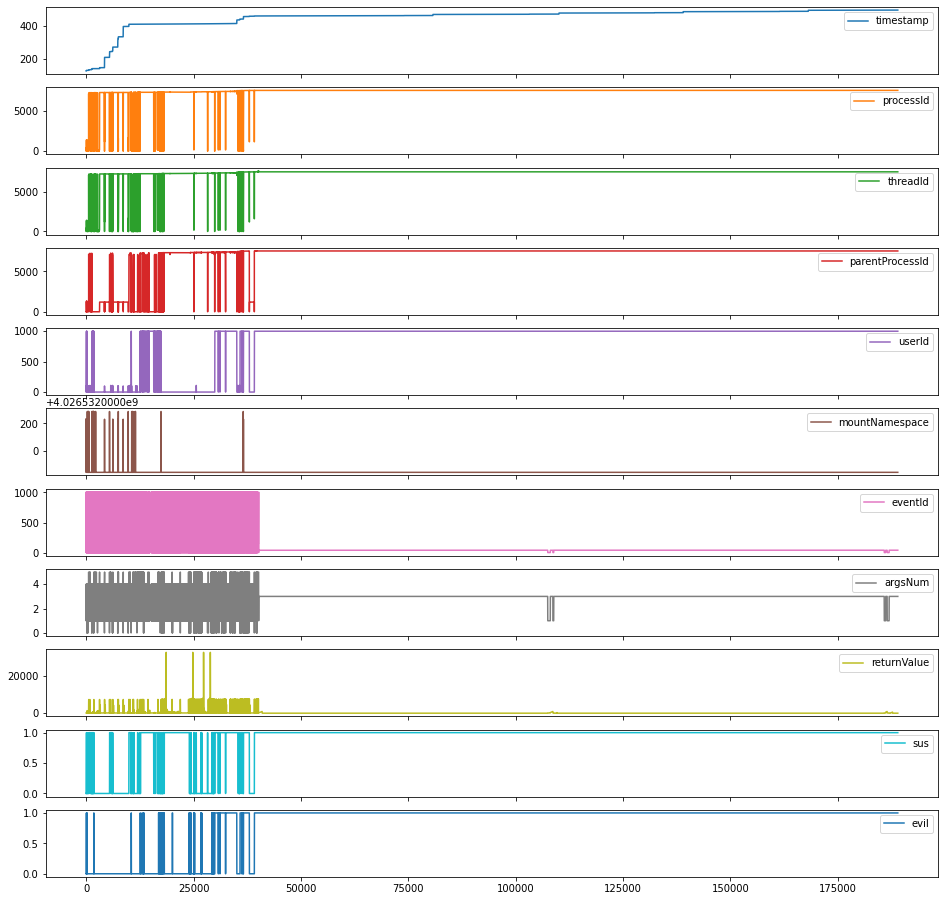

In [7]:

df = pd.read_csv(f'{base_path}/BETH/labelled_testing_data.csv',index_col=False)

df.plot(subplots=True, figsize=(16, 16)); plt.legend(loc='best')

## Preprocessing
The [original paper](http://www.gatsby.ucl.ac.uk/~balaji/udl2021/accepted-papers/UDL2021-paper-033.pdf) outlines the preprocessing steps performed here

* timestamp - nothing
* processId - binary value of weather processID is 0,1,2
* threadId - nothing
* parentProcessId - same as processId
* userId - binary if userId < 1000 or userId >= 1000
* mountNamespace - weather or not mountNamespace = 4026531840 (mnt/ directory)
* processName - encode this (in the future) drop for now
* hostName - nothing (at the moment) drop for now
* eventId - as is
* eventName - drop it
* argsNum - as is
* returnValue - tri-value  -1 when negative, 0 when zero, 1 when positive
* stackAddresses - dropped
* args - dropped

In [8]:
data_raw = df.copy()
# Drop unused columns
data_raw.drop(['processName','hostName','eventName','stackAddresses','args'],axis=1,inplace=True)

# Pre-process remaining columns
data_raw['processId'] = df['processId'].apply(lambda x: (0 <= x <= 2).real)
data_raw['parentProcessId'] = df['parentProcessId'].apply(lambda x: (0 <= x <= 2).real)
data_raw['userId'] = df['userId'].apply(lambda x: (x < 1000).real)
data_raw['mountNamespace'] = df['mountNamespace'].apply(lambda x: (x == 4026531840).real)
data_raw['returnValue'] = df['returnValue'].apply(lambda x: np.sign(x) )

**Fill NA - 0 for numerical and 'NA' for categorical**

In [9]:
# categorical
data_raw[cat_cols] = data_raw[cat_cols].fillna('NA')
data_raw[cat_cols] = data_raw[cat_cols].astype(str)
# non-categorical
non_cat_cols = data_raw.drop(columns=cat_cols + [identifier]).columns.tolist()
data_raw[non_cat_cols] = data_raw[non_cat_cols].fillna(0)

**Constant columns**

In [10]:
const_cols = data_raw.columns[data_raw.nunique() == 1].values.tolist()
data_raw.drop(columns=const_cols, inplace=True)
print('Dropped constant columns:\n{}'.format(const_cols))

Dropped constant columns:
[]


**Train, valid, test dataset split**

In [11]:
data_train, data_valid = train_test_split(data_raw, test_size=0.2, stratify=data_raw[target], random_state=1)
data_valid, data_test = train_test_split(data_valid, test_size=0.5, stratify=data_valid[target], random_state=1)

data_train.reset_index(inplace=True, drop=True)
data_valid.reset_index(inplace=True, drop=True)
data_test.reset_index(inplace=True, drop=True)

# Widedeep network experiment

* based on 
  * [09_Custom_DataLoader_Imbalanced_dataset.ipynb](https://github.com/jrzaurin/pytorch-widedeep/blob/master/examples/09_Custom_DataLoader_Imbalanced_dataset.ipynb)
  * [03_Binary_Classification_with_Defaults](https://github.com/jrzaurin/pytorch-widedeep/blob/master/examples/03_Binary_Classification_with_Defaults.ipynb)

In [12]:
data_train_scaled, Scaler_cls = scale(
    data_train, cat_cols+[target], scaler_sk='Standard')

data_valid_scaled, Scaler_cls = scale(
    data_valid, cat_cols+[target], scaler_sk=Scaler_cls)

data_test_scaled, Scaler_cls = scale(
    data_test, cat_cols+[target], scaler_sk=Scaler_cls)

**[CHECK] Dataset imbalance**

In [13]:
data_train_scaled[target].value_counts()

1    137167
0     14006
Name: sus, dtype: int64

**CUDA vs CPU use in widedeep should be automaticall**

In [14]:
# https://pytorch-widedeep.readthedocs.io/en/latest/_modules/pytorch_widedeep/training/trainer.html?highlight=cuda
os.cpu_count()

8

**[Per class metrics](https://pytorch-widedeep.readthedocs.io/en/latest/metrics.html)**

In [15]:
# Metrics from torchmetrics
accuracy = Accuracy_torchmetrics(average=None, num_classes=2)
accuracy = accuracy.to(device)
precision = Precision_torchmetrics(average='micro', num_classes=2)
precision = precision.to(device)
f1 = F1_torchmetrics(average=None, num_classes=2)
f1 = f1.to(device)
recall = Recall_torchmetrics(average=None, num_classes=2)
recall = recall.to(device)

## Preparing the data

In [16]:
wide_cols = intsec(cat_cols, data_train.columns.values.tolist())
continuous_cols = data_raw.drop(columns=[target]+wide_cols).columns.values.tolist()
#crossed_cols = [('X', 'Y'), ('W', 'Q')]

embed_cols = wide_cols
embed_input = [(u,i) for u,i in zip(embed_cols, [4]*len(embed_cols))]

In [17]:
# wide
wide_preprocessor = WidePreprocessor(wide_cols=wide_cols)
X_wide_train = wide_preprocessor.fit_transform(data_train_scaled)
X_wide_valid = wide_preprocessor.transform(data_valid_scaled)
X_wide_test = wide_preprocessor.transform(data_test_scaled)

# deeptabular
tab_preprocessor = TabPreprocessor(#embed_cols=embed_input,
                                   continuous_cols=continuous_cols,
                                   scale=False)
X_tab_train = tab_preprocessor.fit_transform(data_train_scaled)
X_tab_valid = tab_preprocessor.transform(data_valid_scaled)
X_tab_test = tab_preprocessor.transform(data_test_scaled)

# target
y_train = data_train_scaled[target].values
y_valid = data_valid_scaled[target].values
y_test = data_test_scaled[target].values

C:\ProgramData\Anaconda3\envs\FIREMAN-project\lib\site-packages\pytorch_widedeep\preprocessing\tab_preprocessor.py:179: UserWarning: Continuous columns will not be normalised
  warnings.warn("Continuous columns will not be normalised")


## Defining the model
* batchnorm at each layers in combination with scaling of input layers helps with [efficiency of backprop](https://stats.stackexchange.com/a/328988)

**[OPTIONAL] test different hidden layer designs**

In [18]:
input_layer = len(tab_preprocessor.continuous_cols)
output_layer = 1

lengths = [3,5,7,9,11]

pipes = []
anti_autoencoders = []
trapezoids = []
anti_trapezoids = []
funnels = []
adj_funnels = []
apollos = []

for length in lengths:
    pipe = [input_layer]*length
    pipes.append(pipe)
    anti_autoencoder = np.linspace(input_layer, input_layer*2, ceil(length/2), dtype=int).tolist()
    anti_autoencoder.extend(anti_autoencoder[-2::-1])
    anti_autoencoders.append(anti_autoencoder)
    trapezoid = np.array([round(input_layer*1.25)]*length)
    trapezoid[[0, -1]] = input_layer
    trapezoids.append(trapezoid.tolist())
    anti_trapezoid = np.array([round(input_layer*0.75)]*length)
    anti_trapezoid[[0, -1]] = input_layer
    anti_trapezoids.append(anti_trapezoid.tolist())
    funnel = np.linspace(input_layer*2, output_layer, length, endpoint=False, dtype=int).tolist()
    funnels.append(funnel)
    adj_funnel = np.linspace(input_layer*2, output_layer, length, endpoint=False, dtype=int).tolist()
    adj_funnel.insert(0, input_layer)
    adj_funnels.append(adj_funnel)
    apollo = np.linspace(input_layer, input_layer*2, length, dtype=int).tolist()
    apollos.append(apollo)

In [19]:
input_layer = len(tab_preprocessor.continuous_cols)
output_layer = 1
hidden_layers = np.linspace(input_layer*2, output_layer, 5, endpoint=False, dtype=int).tolist()

In [20]:
wide = Wide(wide_dim=wide_preprocessor.wide_dim)
'''
deeptabular = SAINT(mlp_hidden_dims=hidden_layers,
                     column_idx=tab_preprocessor.column_idx,
                     #embed_input=tab_preprocessor.embeddings_input,
                     continuous_cols=tab_preprocessor.continuous_cols,
                     mlp_batchnorm=True,
                     mlp_batchnorm_last=True,
                     mlp_linear_first=True)
'''
deeptabular = TabMlp(mlp_hidden_dims=hidden_layers,
                     column_idx=tab_preprocessor.column_idx,
                     #embed_input=tab_preprocessor.embeddings_input,
                     continuous_cols=tab_preprocessor.continuous_cols,
                     mlp_batchnorm=True,
                     mlp_batchnorm_last=True,
                     mlp_linear_first=True)
model = WideDeep(wide=wide, deeptabular=deeptabular)

In [21]:
model

WideDeep(
  (wide): Wide(
    (wide_linear): Embedding(18, 1, padding_idx=0)
  )
  (deeptabular): Sequential(
    (0): TabMlp(
      (cat_embed_and_cont): CatEmbeddingsAndCont(
        (cont_norm): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (tab_mlp): MLP(
        (mlp): Sequential(
          (dense_layer_0): Sequential(
            (0): Linear(in_features=4, out_features=8, bias=False)
            (1): ReLU(inplace=True)
            (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): Dropout(p=0.1, inplace=False)
          )
          (dense_layer_1): Sequential(
            (0): Linear(in_features=8, out_features=6, bias=False)
            (1): ReLU(inplace=True)
            (2): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): Dropout(p=0.1, inplace=False)
          )
          (dense_layer_2): Sequential(
            (0): Linear(in_featur

**Optimizers, LR schedulers, Initializers**

In [22]:
# Optimizers
wide_opt = SGD(model.wide.parameters(), lr=0.01)
deep_opt = SGD(model.deeptabular.parameters(), lr=0.01)
# LR Schedulers
wide_sch = lr_scheduler.StepLR(wide_opt, step_size=3)
deep_sch = lr_scheduler.StepLR(deep_opt, step_size=3)

**Train**

In [ ]:
early_stopping = EarlyStopping()
model_checkpoint = ModelCheckpoint(filepath="/#datasets/temp/wide",
                                   save_best_only=True,
                                   verbose=1,
                                   max_save=1)

trainer = Trainer(model,
                  objective="binary_focal_loss",
                  callbacks=[LRHistory(n_epochs=10), early_stopping, model_checkpoint],
                  lr_schedulers={'wide': wide_sch, 'deeptabular':deep_sch},
                  initializers={'wide': XavierNormal, 'deeptabular':XavierNormal},
                  optimizers = {'wide': wide_opt, 'deeptabular':deep_opt},
                  metrics=[accuracy, precision, recall, f1])

trainer.fit(X_train={"X_wide": X_wide_train, "X_tab": X_tab_train, "target": y_train},
            X_val={"X_wide": X_wide_valid, "X_tab": X_tab_valid, "target": y_valid},
            n_epochs=10,
            batch_size=1000,
            custom_dataloader=DataLoaderImbalanced,
            oversample_mul=5)

  0%|          | 0/141 [00:00<?, ?it/s]sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x23219a832e0>


In [ ]:
pd.DataFrame(trainer.history)

In [ ]:
pd.DataFrame(trainer.lr_history)

**Predict**

In [ ]:
data_pred = trainer.predict(X_wide=X_wide_test, X_tab=X_tab_test)
print(classification_report(data_test[target].to_list(), data_pred))